# Tutorial 03: Multi-Survey Cross-Matching with HEALPix

**Learning Objectives:**
- Understand how astronomical surveys organize data spatially using HEALPix
- Learn to download and access HEALPix-partitioned data
- Perform spatial cross-matching with astropy
- Combine data from optical, spectroscopic, and X-ray surveys

This tutorial demonstrates how to cross-match sources from multiple astronomical surveys (Gaia, SDSS, and Chandra) by downloading HEALPix-partitioned data and performing spatial matching.

## Setup and Imports

In [2]:
import subprocess
from pathlib import Path
import h5py
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt

## Part 1: Understanding HEALPix Spatial Indexing

**What is HEALPix?**

HEALPix (Hierarchical Equal Area isoLatitude Pixelization) divides the sky into equal-area pixels, making it ideal for large astronomical surveys.

**Key Properties:**
- Equal-area pixels (important for statistics)
- Hierarchical structure (nside = 2^k)
- Each pixel has unique integer ID
- Used by: Planck, SDSS, Gaia, MultimodalUniverse

**For MultimodalUniverse:**
- Data organized by HEALPix pixel at nside=32
- This creates 12,288 pixels covering the full sky
- Each pixel ≈ 13.4 square degrees
- Sources in same region share HEALPix ID

**Why HEALPix for cross-matching?**
- Only need to download overlapping pixels
- Fast spatial queries within pixels
- Efficient for distributed data storage

## Part 2: Selecting a HEALPix Region

For this tutorial, we'll use **HEALPix pixel 583**.

In [3]:
# Select HEALPix pixel
healpix = 583
print(f"Selected HEALPix pixel: {healpix}")

# Create data directory structure
print("\nCreating data directory structure...")
Path("data/MultimodalUniverse/v1/gaia").mkdir(parents=True, exist_ok=True)
Path("data/MultimodalUniverse/v1/sdss").mkdir(parents=True, exist_ok=True)
Path("data/MultimodalUniverse/v1/chandra/spectra").mkdir(parents=True, exist_ok=True)
print("✅ Directories created")

Selected HEALPix pixel: 583

Creating data directory structure...
✅ Directories created


## Part 3: Downloading Survey Data

We'll download data from three surveys:
1. **Gaia** - Optical astrometry and photometry (baseline catalog)
2. **SDSS** - Optical spectroscopy with redshifts (including all sub-surveys)
3. **Chandra** - X-ray source catalog

**Data format:**
- HDF5 files (.hdf5) - Efficient binary format
- Direct column access without loading full file
- Standard in astronomy for large datasets

IMPORTANT NOTE:
- Mac and Linux users will be able to run the "wget" command. On Windows, you'll need to use the "requests" functionality. I've included both below.

In [ ]:
# Download Gaia data
print("[1/3] Downloading Gaia data...")

try:
    subprocess.run([
        "wget", "-r", "-np", "-nH", "--cut-dirs=1",
        "-R", "index.html*", "-q",
        f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/"
    ], check=True)
    print("  ✅ Gaia data downloaded")
except:
    # Use requests to download the file (single file example)
    import requests

    gaia_url = f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/001-of-001.hdf5"
    gaia_local_path = f"data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/001-of-001.hdf5"

    # Make sure the directory exists
    Path(f"data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}").mkdir(parents=True, exist_ok=True)

    response = requests.get(gaia_url, stream=True)
    if response.status_code == 200:
        with open(gaia_local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("  ✅ Gaia data downloaded")
    else:
        print(f"  ❌ Failed to download Gaia data (status code: {response.status_code})")

[1/3] Downloading Gaia data...
  ✅ Gaia data downloaded


In [9]:
import requests

# Download SDSS data (all sub-surveys)
print("[2/3] Downloading SDSS spectroscopic data (all sub-surveys)...")
print("     SDSS includes: sdss, boss, eboss, segue1, segue2")
sdss_subsurveys = ['sdss', 'boss', 'eboss', 'segue1', 'segue2']

for subsurvey in sdss_subsurveys:
    print(f"     Downloading {subsurvey}...", end=" ")
    try:
        subprocess.run([
            "wget", "-r", "-np", "-nH", "--cut-dirs=1",
            "-R", "index.html*", "-q",
            f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/sdss/{subsurvey}/healpix={healpix}/"
        ], check=True)
        print("✓")
    except:
        # Use requests to download the file (single file example)
        
        sdss_url = f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/sdss/{subsurvey}/healpix={healpix}/001-of-001.hdf5"
        sdss_local_path = f"data/MultimodalUniverse/v1/sdss/{subsurvey}/healpix={healpix}/001-of-001.hdf5"
        
        # Make sure the directory exists
        Path(f"data/MultimodalUniverse/v1/sdss/{subsurvey}/healpix={healpix}").mkdir(parents=True, exist_ok=True)
        
        response = requests.get(sdss_url, stream=True)
        if response.status_code == 200:
            with open(sdss_local_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("✓")
        else:
            print("(no data for this HEALPix)")

print("  ✅ SDSS data downloaded (all available sub-surveys)")

[2/3] Downloading SDSS spectroscopic data (all sub-surveys)...
     SDSS includes: sdss, boss, eboss, segue1, segue2
  ✅ SDSS data downloaded (all available sub-surveys)


In [16]:
# Download Chandra data
print("[3/3] Downloading Chandra X-ray data...")

try:
    subprocess.run([
        "wget", "-r", "-np", "-nH", "--cut-dirs=1",
        "-R", "index.html*", "-q",
        f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/"
    ], check=True)
except:
    # Use requests to download the file (single file example)
    
    chandra_url = f"https://users.flatironinstitute.org/~polymathic/data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/001-of-001.hdf5"
    chandra_local_path = f"data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/001-of-001.hdf5"
    
    # Make sure the directory exists
    Path(f"data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}").mkdir(parents=True, exist_ok=True)
    
    response = requests.get(chandra_url, stream=True)
    if response.status_code == 200:
        with open(chandra_local_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f"  ❌ Failed to download Chandra data (status code: {response.status_code})")
        
print("  ✅ Chandra data downloaded")

[3/3] Downloading Chandra X-ray data...
  ✅ Chandra data downloaded
  ✅ Chandra data downloaded


IMPORTANT NOTES: 
- The names of the actual file locations can be a bit confusing, so try to explore the directory structure online (via either the Flatiron website or Globus) to know what name(s) to use. (Or just do analysis with streaming data in batches following the syntax in the previous tutorial notebook.)
- Some of the data files can be pretty large since they contain both information about the objects (brightness, etc.) as well as full images, spectra, and other metadata. In those cases, if you are downloading the data beforehand, it is recommended you download data one healpix at a time and then delete the entries you don't need (e.g., all images if you just want G-band magnitudes). You can also use Globus for faster transfers if your network has the capacity for it.

## Part 4: Understanding HDF5 File Structure

**HDF5 (Hierarchical Data Format) files store:**
- Multiple datasets (columns) in one file
- Metadata about each dataset
- Efficient random access to columns
- Compressed data

**Advantages:**
- Read only needed columns
- Fast I/O for large datasets
- Self-describing format

In [17]:
# Define file paths
gaia_file = f"data/MultimodalUniverse/v1/gaia/gaia/healpix={healpix}/001-of-001.hdf5"
chandra_file = f"data/MultimodalUniverse/v1/chandra/spectra/healpix={healpix}/001-of-001.hdf5"

# Explore Gaia HDF5 structure
print(f"Exploring Gaia HDF5 file structure:")
print(f"File: {gaia_file}")
with h5py.File(gaia_file, 'r') as f:
    print(f"  Number of datasets (columns): {len(f.keys())}")
    print(f"  Number of sources: {len(f['ra'][:])}") 
    print(f"\n  Key columns:")
    key_cols = ['ra', 'dec', 'parallax', 'phot_g_mean_mag', 'source_id']
    for col in key_cols:
        if col in f.keys():
            print(f"    - {col:20s}: {f[col].shape}")

Exploring Gaia HDF5 file structure:
File: data/MultimodalUniverse/v1/gaia/gaia/healpix=583/001-of-001.hdf5
  Number of datasets (columns): 154
  Number of sources: 23982

  Key columns:
    - ra                  : (23982,)
    - dec                 : (23982,)
    - parallax            : (23982,)
    - phot_g_mean_mag     : (23982,)
    - source_id           : (23982,)


## Part 5: Loading Catalog Data

Now we'll load the data from each survey catalog. For SDSS, we'll combine all sub-surveys (sdss, boss, eboss, segue1, segue2) into a single catalog.

In [18]:
# Load Gaia catalog (our baseline)
print("Loading Gaia catalog (our baseline)...")
with h5py.File(gaia_file, 'r') as f:
    gaia_ra = f['ra'][:]
    gaia_dec = f['dec'][:]
    gaia_parallax = f['parallax'][:]
    gaia_g_mag = f['phot_g_mean_mag'][:]
    print(f"  ✅ Loaded {len(gaia_ra):,} Gaia sources")

Loading Gaia catalog (our baseline)...
  ✅ Loaded 23,982 Gaia sources


In [19]:
# Load SDSS catalog (all sub-surveys)
print("Loading SDSS catalog (all sub-surveys)...")
sdss_ra_list = []
sdss_dec_list = []
sdss_z_list = []

for subsurvey in sdss_subsurveys:
    sdss_file = f"data/MultimodalUniverse/v1/sdss/{subsurvey}/healpix={healpix}/001-of-001.hdf5"
    if Path(sdss_file).exists():
        with h5py.File(sdss_file, 'r') as f:
            n_sources = len(f['ra'][:])
            print(f"    - {subsurvey}: {n_sources:,} sources")
            sdss_ra_list.append(f['ra'][:])
            sdss_dec_list.append(f['dec'][:])
            sdss_z_list.append(f['Z'][:])
    else:
        print(f"    - {subsurvey}: no data for this HEALPix")

# Concatenate all sub-surveys
if sdss_ra_list:
    sdss_ra = np.concatenate(sdss_ra_list)
    sdss_dec = np.concatenate(sdss_dec_list)
    sdss_z = np.concatenate(sdss_z_list)
    print(f"  ✅ Loaded {len(sdss_ra):,} total SDSS sources (all sub-surveys)")
else:
    print("  ⚠️  No SDSS data available for this HEALPix")
    sdss_ra = np.array([])
    sdss_dec = np.array([])
    sdss_z = np.array([])

Loading SDSS catalog (all sub-surveys)...
    - sdss: 364 sources
    - boss: 2,135 sources
    - eboss: 2,511 sources
    - segue1: no data for this HEALPix
    - segue2: 760 sources
  ✅ Loaded 5,770 total SDSS sources (all sub-surveys)


In [20]:
# Load Chandra catalog
print("Loading Chandra catalog...")
with h5py.File(chandra_file, 'r') as f:
    chandra_ra = f['ra'][:]
    chandra_dec = f['dec'][:]
    # Chandra has flux in different energy bands
    if 'flux_aper_b' in f.keys():
        chandra_flux = f['flux_aper_b'][:]
    else:
        chandra_flux = np.ones(len(chandra_ra))  # placeholder
    print(f"  ✅ Loaded {len(chandra_ra):,} Chandra sources")

Loading Chandra catalog...
  ✅ Loaded 19 Chandra sources


## Part 6: Spatial Cross-Matching

**Cross-matching strategy:**
1. Use Gaia as baseline (most sources, best astrometry)
2. Match SDSS to Gaia (1 arcsec radius)
3. Match Chandra to Gaia (2 arcsec radius - X-ray positions less precise)

**Matching radius considerations:**
- Gaia: ~0.1 mas positional accuracy
- SDSS: ~0.1 arcsec positional accuracy
- Chandra: ~0.5-1 arcsec positional accuracy

In [21]:
# Create SkyCoord objects
print("Creating coordinate objects...")
gaia_coords = SkyCoord(ra=gaia_ra*u.deg, dec=gaia_dec*u.deg)
if len(sdss_ra) > 0:
    sdss_coords = SkyCoord(ra=sdss_ra*u.deg, dec=sdss_dec*u.deg)
chandra_coords = SkyCoord(ra=chandra_ra*u.deg, dec=chandra_dec*u.deg)
print("  ✅ Coordinate objects created")

Creating coordinate objects...
  ✅ Coordinate objects created


In [26]:
# Match SDSS to Gaia
if len(sdss_ra) > 0:
    print("[1/2] Matching SDSS to Gaia (1 arcsec radius)...")
    idx_sdss_gaia, sep2d_sdss, _ = sdss_coords.match_to_catalog_sky(gaia_coords)
    match_mask_sdss = sep2d_sdss < 1.0 * u.arcsec
    n_gaia_sdss = np.sum(match_mask_sdss)
    print(f"  ✅ Found {n_gaia_sdss} Gaia-SDSS matches")
    if n_gaia_sdss > 0:
        print(f"     Median separation: {np.median(sep2d_sdss[match_mask_sdss].arcsec):.3f} arcsec")
else:
    print("[1/2] Skipping SDSS matching (no SDSS data available)")
    idx_sdss_gaia = np.array([])
    sep2d_sdss = np.array([]) * u.arcsec
    match_mask_sdss = np.array([], dtype=bool)
    n_gaia_sdss = 0

[1/2] Matching SDSS to Gaia (1 arcsec radius)...
  ✅ Found 483 Gaia-SDSS matches
     Median separation: 0.094 arcsec


In [27]:
# Match Chandra to Gaia
print("[2/2] Matching Chandra to Gaia (2 arcsec radius)...")
idx_chandra_gaia, sep2d_chandra, _ = chandra_coords.match_to_catalog_sky(gaia_coords)
match_mask_chandra = sep2d_chandra < 3.0 * u.arcsec
n_gaia_chandra = np.sum(match_mask_chandra)
print(f"  ✅ Found {n_gaia_chandra} Gaia-Chandra matches")
print(f"     Median separation: {np.median(sep2d_chandra[match_mask_chandra].arcsec):.3f} arcsec")

[2/2] Matching Chandra to Gaia (2 arcsec radius)...
  ✅ Found 1 Gaia-Chandra matches
     Median separation: 0.510 arcsec


## Part 7: Creating Multi-Wavelength Catalogs

We'll create three catalogs:
1. **Gaia-SDSS**: Optical + spectroscopy
2. **Gaia-Chandra**: Optical + X-ray
3. **Gaia-SDSS-Chandra**: Complete multi-wavelength (rarest)

In [28]:
# Create Gaia-SDSS matches catalog
gaia_sdss_matches = []
for i, has_match in enumerate(match_mask_sdss):
    if has_match:
        gaia_idx = idx_sdss_gaia[i]
        gaia_sdss_matches.append({
            'ra': gaia_ra[gaia_idx],
            'dec': gaia_dec[gaia_idx],
            'gaia_g_mag': gaia_g_mag[gaia_idx],
            'gaia_parallax': gaia_parallax[gaia_idx],
            'sdss_z': sdss_z[i],
            'separation_arcsec': sep2d_sdss[i].arcsec
        })

df_gaia_sdss = pd.DataFrame(gaia_sdss_matches)
print(f"✅ Gaia-SDSS catalog: {len(df_gaia_sdss)} sources")

✅ Gaia-SDSS catalog: 483 sources


In [29]:
# Create Gaia-Chandra matches catalog
gaia_chandra_matches = []
for i, has_match in enumerate(match_mask_chandra):
    if has_match:
        gaia_idx = idx_chandra_gaia[i]
        gaia_chandra_matches.append({
            'ra': gaia_ra[gaia_idx],
            'dec': gaia_dec[gaia_idx],
            'gaia_g_mag': gaia_g_mag[gaia_idx],
            'gaia_parallax': gaia_parallax[gaia_idx],
            'chandra_flux': chandra_flux[i],
            'separation_arcsec': sep2d_chandra[i].arcsec
        })

df_gaia_chandra = pd.DataFrame(gaia_chandra_matches)
print(f"✅ Gaia-Chandra catalog: {len(df_gaia_chandra)} sources")

✅ Gaia-Chandra catalog: 1 sources


In [30]:
# Find triple matches (Gaia-SDSS-Chandra)
print("Finding triple matches (Gaia + SDSS + Chandra)...")
gaia_sdss_indices = set(idx_sdss_gaia[match_mask_sdss])
gaia_chandra_indices = set(idx_chandra_gaia[match_mask_chandra])
gaia_triple_indices = gaia_sdss_indices.intersection(gaia_chandra_indices)

print(f"✅ Triple matches: {len(gaia_triple_indices)} sources")
print(f"   (Optical + Spectroscopy + X-ray)")

Finding triple matches (Gaia + SDSS + Chandra)...
✅ Triple matches: 0 sources
   (Optical + Spectroscopy + X-ray)


## Part 8: Analyzing Cross-Match Results

In [31]:
# Summary statistics
sdss_pct = 100*len(df_gaia_sdss)/len(sdss_ra) if len(sdss_ra) > 0 else 0
chandra_pct = 100*len(df_gaia_chandra)/len(chandra_ra) if len(chandra_ra) > 0 else 0

print(f"""
Cross-Match Summary:
-------------------
Base catalog (Gaia):           {len(gaia_ra):,} sources
SDSS spectroscopy:             {len(sdss_ra):,} sources
Chandra X-ray:                 {len(chandra_ra):,} sources

Matches:
  Gaia-SDSS:                   {len(df_gaia_sdss):,} ({sdss_pct:.1f}% of SDSS)
  Gaia-Chandra:                {len(df_gaia_chandra):,} ({chandra_pct:.1f}% of Chandra)
  Gaia-SDSS-Chandra (triple):  {len(gaia_triple_indices):,}

Match fractions:
  SDSS with Gaia match:        {sdss_pct:.1f}%
  Chandra with Gaia match:     {chandra_pct:.1f}%
""")


Cross-Match Summary:
-------------------
Base catalog (Gaia):           23,982 sources
SDSS spectroscopy:             5,770 sources
Chandra X-ray:                 19 sources

Matches:
  Gaia-SDSS:                   483 (8.4% of SDSS)
  Gaia-Chandra:                1 (5.3% of Chandra)
  Gaia-SDSS-Chandra (triple):  0

Match fractions:
  SDSS with Gaia match:        8.4%
  Chandra with Gaia match:     5.3%



## Part 9: Visualizing Multi-Wavelength Data

✅ Saved visualization to tutorial04_crossmatch_analysis.png


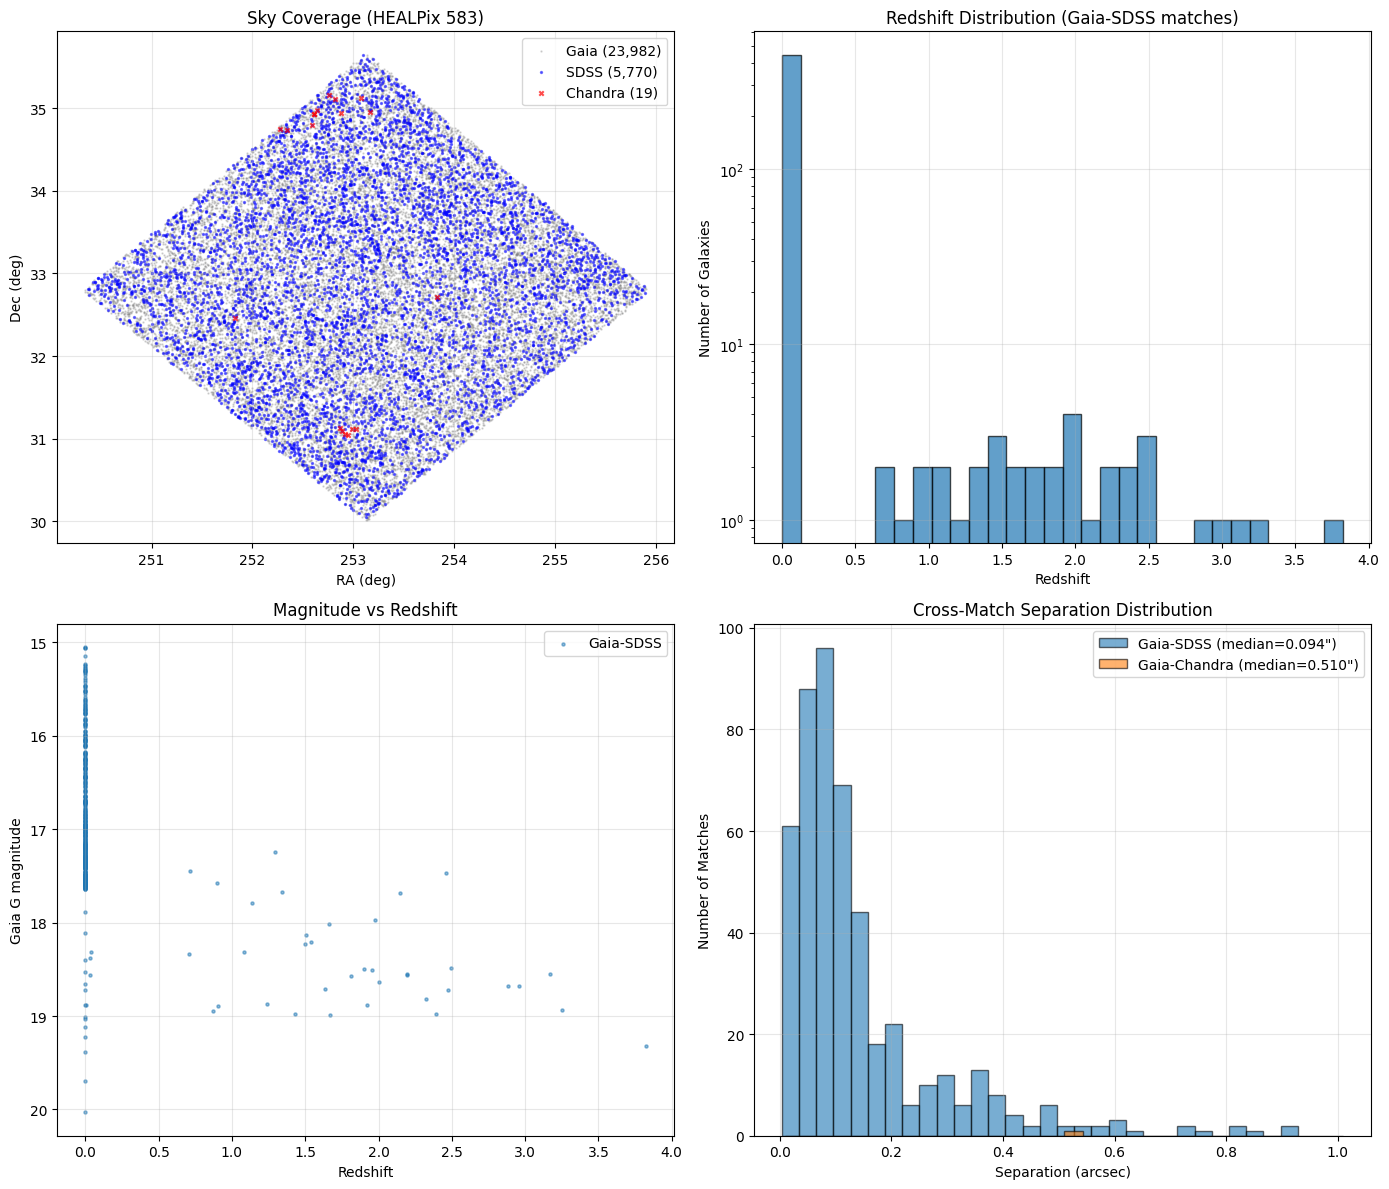

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Sky positions
ax = axes[0, 0]
ax.scatter(gaia_ra, gaia_dec, s=0.5, alpha=0.3, label=f'Gaia ({len(gaia_ra):,})', c='gray')
if len(sdss_ra) > 0:
    ax.scatter(sdss_ra, sdss_dec, s=2, alpha=0.5, label=f'SDSS ({len(sdss_ra):,})', c='blue')
ax.scatter(chandra_ra, chandra_dec, s=10, alpha=0.7, label=f'Chandra ({len(chandra_ra):,})', c='red', marker='x')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_title(f'Sky Coverage (HEALPix {healpix})')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Redshift distribution (Gaia-SDSS matches)
ax = axes[0, 1]
if len(df_gaia_sdss) > 0:
    ax.hist(df_gaia_sdss['sdss_z'], bins=30, edgecolor='black', alpha=0.7, log=True),
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Number of Galaxies')
    ax.set_title('Redshift Distribution (Gaia-SDSS matches)')
else:
    ax.text(0.5, 0.5, 'No Gaia-SDSS matches', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Redshift Distribution (Gaia-SDSS matches)')
ax.grid(True, alpha=0.3)

# Plot 3: Magnitude vs Redshift
ax = axes[1, 0]
if len(df_gaia_sdss) > 0:
    ax.scatter(df_gaia_sdss['sdss_z'], df_gaia_sdss['gaia_g_mag'],
              s=5, alpha=0.5, label='Gaia-SDSS')
    ax.set_xlabel('Redshift')
    ax.set_ylabel('Gaia G magnitude')
    ax.set_title('Magnitude vs Redshift')
    ax.invert_yaxis()
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No Gaia-SDSS matches', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Magnitude vs Redshift')
ax.grid(True, alpha=0.3)

# Plot 4: Match separation distributions
ax = axes[1, 1]
if len(df_gaia_sdss) > 0:
    ax.hist(df_gaia_sdss['separation_arcsec'], bins=30, alpha=0.6,
           label=f'Gaia-SDSS (median={np.median(df_gaia_sdss["separation_arcsec"]):.3f}")',
           edgecolor='black')
if len(df_gaia_chandra) > 0:
    ax.hist(df_gaia_chandra['separation_arcsec'], bins=30, alpha=0.6,
           label=f'Gaia-Chandra (median={np.median(df_gaia_chandra["separation_arcsec"]):.3f}")',
           edgecolor='black')
ax.set_xlabel('Separation (arcsec)')
ax.set_ylabel('Number of Matches')
ax.set_title('Cross-Match Separation Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tutorial04_crossmatch_analysis.png', dpi=150, bbox_inches='tight')
print("✅ Saved visualization to tutorial04_crossmatch_analysis.png")
plt.show()

## Part 10: Saving Cross-Matched Catalogs

In [36]:
# Save catalogs
df_gaia_sdss.to_csv('tutorial03_gaia_sdss_matches.csv', index=False)
print(f"✅ Saved Gaia-SDSS catalog: tutorial03_gaia_sdss_matches.csv")

df_gaia_chandra.to_csv('tutorial03_gaia_chandra_matches.csv', index=False)
print(f"✅ Saved Gaia-Chandra catalog: tutorial03_gaia_chandra_matches.csv")

✅ Saved Gaia-SDSS catalog: tutorial03_gaia_sdss_matches.csv
✅ Saved Gaia-Chandra catalog: tutorial03_gaia_chandra_matches.csv


## Summary and Next Steps

### What we learned:
1. HEALPix spatial indexing for astronomical surveys
2. Downloading HEALPix-partitioned data efficiently
3. Reading HDF5 files with h5py
4. Spatial cross-matching with astropy SkyCoord
5. Creating multi-wavelength catalogs

### Next Steps:
1. Analyze redshift distribution of matched galaxies
2. Study X-ray to optical flux ratios
3. Identify AGN candidates (X-ray bright sources)
4. Cross-match with additional surveys (WISE, 2MASS, etc.)
5. Use matched catalogs for science analysis

### Examples of Scientific Applications:
- AGN identification and classification
- Galaxy evolution across cosmic time
- Multi-wavelength SEDs
- Stellar population studies
- Variable and transient source identification